# Calorimeter regression task

In this project you will be looking at image like data from particle hits in a calorimeter. The goal of the project is to predict the location of the particle in the sky, using the data recorded by the calorimeter. Look in the `README.md` for more information.

First download the data, and then un-zip the data with `tar -zxvf data.tar.gz` into a data folder.
1. You can then use the functions within `utils.py` to load the data
2. We run `get_input_data` below to load in the images 

You may need to edit the `get_input_data` function in `utils.py` to have the right path.

## The training data
Here you get calorimeter images, as well as some additional information about the calorimeter.
The calorimeter data has the total energy of the corresponding image in the first column, and the calorimeter energy of the maximum bar.

## The target data
The target here is a vector of length four, where the first two columns are the x coordinates at the bottom and top, and then the y positions at the top and the bottom. To simplify the task, you can try predicting each layer individually, before attempting both layers together.
Top and bottom is relative to the tracker in the detector at -40mm and -200mm in z.


In [61]:
import os 
from utils import get_input_data
import numpy as np 
from helpers import split_xy_intercept
from plotter import plot_image
import matplotlib.pyplot as plt

# ML tools 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, Input, losses

Load all the data

In [2]:
calorimeter_images, calorimeter_data, data_target, benchmark_data = get_input_data()

In [3]:
# Normalize the data 
calorimeter_images = calorimeter_images / 255.0
# calorimeter_images = calorimeter_images.reshape(calorimeter_images.shape[:3])/ 255.0

#### Data structure:

`calorimeter_images`: Calorimeter images

`calorimeter_data`: Calorimeter 2 variables  - bgoene (CALO total energy), maxbar (CALO energy of maximum bar)

`data_target`: Truth/target 4 variables - normally variables that are targeted at the regression optimisation,
say x_bot, x_top, y_bot, y_top

`benchmark_data`: Benchmark predictions 4 variables - Obtained from the standard BGO rec direction, x_bot, x_top, y_bot, y_top 

In [4]:
print(f"Input images of shape: {calorimeter_images.shape}255. and type {type(calorimeter_images)}")
print(f"Input data of shape: {calorimeter_data.shape} and type {type(calorimeter_data)}")
print(f"Target data of shape: {data_target.shape} and type {type(data_target)}")
print(f"Benchmark data of shape: {benchmark_data.shape} and type {type(benchmark_data)}")

Input images of shape: (141946, 14, 22, 1)255. and type <class 'numpy.ndarray'>
Input data of shape: (141946, 2) and type <class 'numpy.ndarray'>
Target data of shape: (141946, 4) and type <class 'numpy.ndarray'>
Benchmark data of shape: (141946, 4) and type <class 'numpy.ndarray'>


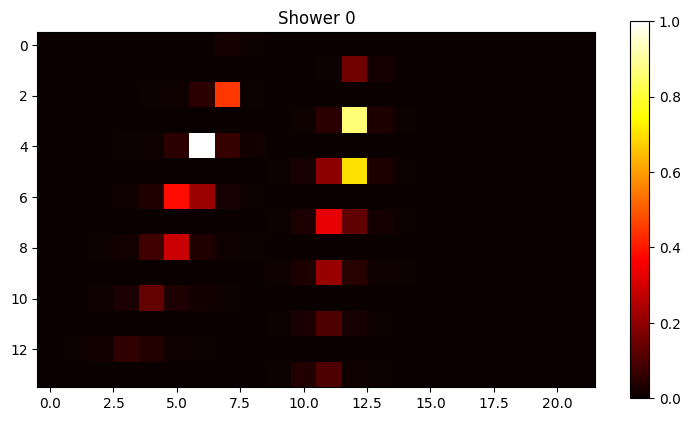

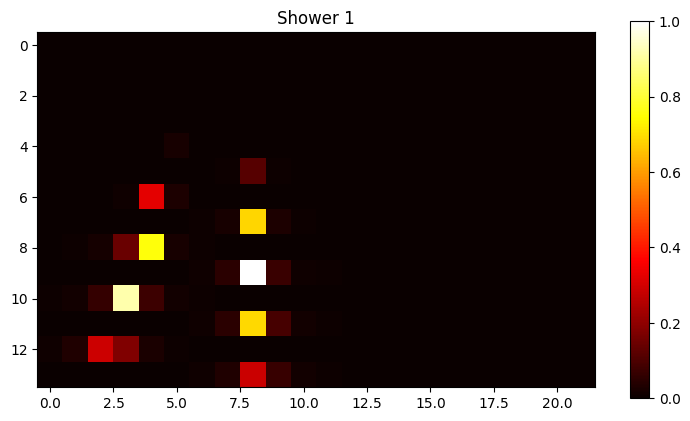

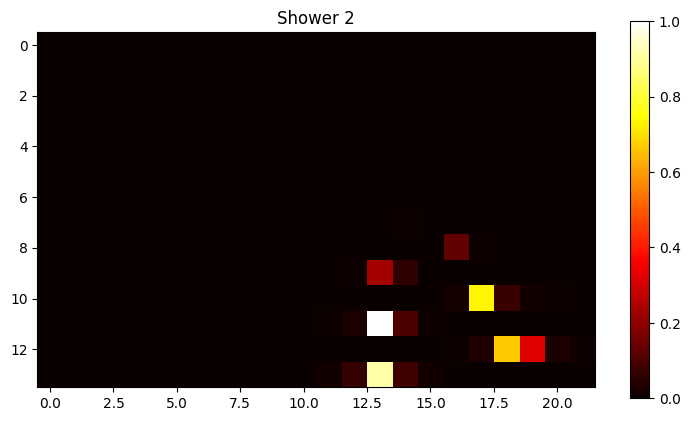

In [5]:
%matplotlib inline
#fig,axes = plt.subplots(nrows=1,ncols=3,figsize=(21,6))
for i in range(3):
    plot_image(calorimeter_images[i], image_name = 'Shower {}'.format(i))

Here we can see the structure of the data in image format for the first three showers.

The total energy of the shower and the max energy of a bar are also shown.

Note that there seem to be two lines alternating every row - this is the x-z and y-z split of the calormiter alternating each layer!

**The exercises can be found in the `README.md`**


Question : Is it starting with the x intercept or with the y intercept? Is the first row the x intercept and the second the y intercept or is it reversed?

In [6]:
print(calorimeter_images.shape)
X, Y = split_xy_intercept(calorimeter_images)
print(X.shape)
print(Y.shape)

(141946, 14, 22, 1)
(141946, 7, 22, 1)
(141946, 7, 22, 1)


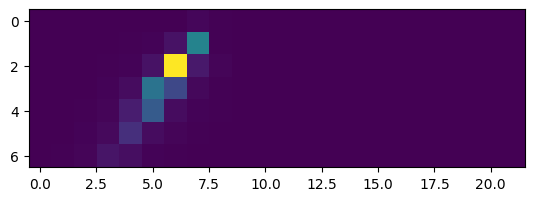

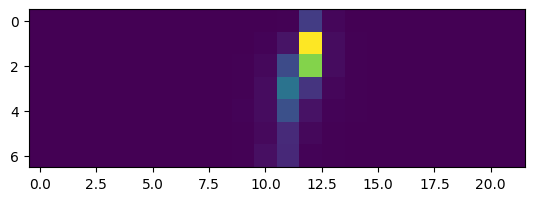

In [7]:
plt.imshow(X[0])
plt.show()
plt.imshow(Y[0])
plt.show()

Plot the image

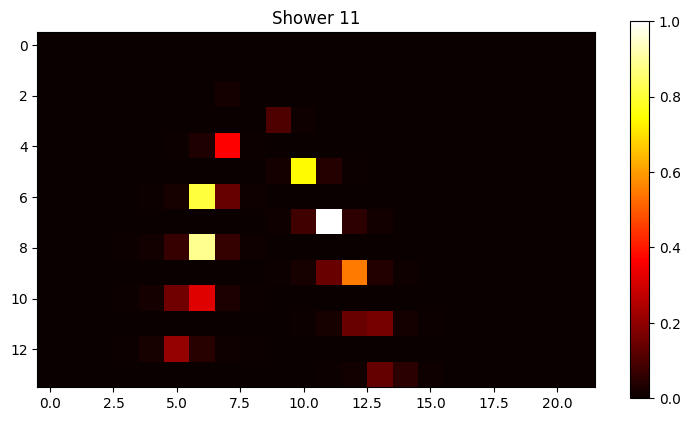

[18382280.   2695997.5]
[-173.23228  -106.88785   -33.886196  -64.71952 ]
[-173.8  -106.94  -38.3   -67.75]


In [8]:
shower_n = 11
plot_image(calorimeter_images[shower_n], image_name = 'Shower {}'.format(shower_n))

# Show the data first 
print(calorimeter_data[shower_n])
print(data_target[shower_n])
print(benchmark_data[shower_n])

Without further processing we directly apply a convolutional neural network for the regression task.

We start by spliting in 3 sets : \
Test  \
Train \
Validation

In [9]:
# Merge to shuffle
# Not used 
data_full = [ [ calorimeter_images[ii], data_target[ii] ] for ii in range( calorimeter_images.shape[0]) ]
# Shuffle 

In [10]:
# Normalize the data
# Split parameters
test_size = 0.25
val_size = 0.3

# Test split 
Im_train, Im_test, xy_train, xy_test = train_test_split(calorimeter_images, data_target, test_size = test_size)
# Validation split
Im_test , Im_val , xy_test , xy_val  = train_test_split(Im_test, xy_test, test_size = val_size)

<function matplotlib.pyplot.show(close=None, block=None)>

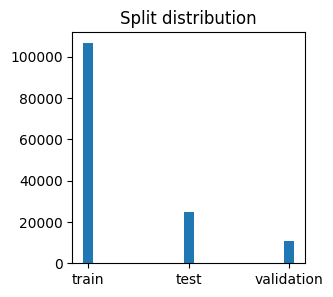

In [11]:
plt.figure(figsize=(3,3))
plt.bar(['train', 'test', 'validation'],[xy_train.shape[0], xy_test.shape[0], xy_val.shape[0]], width=0.1)
plt.title('Split distribution')
plt.show

In [13]:
calorimeter_images.shape

(141946, 14, 22, 1)

In [51]:
# Convolutional neural network 
model = models.Sequential()
model.add(Input(shape=calorimeter_images[0].shape))
model.add(layers.Conv2D(filters=32, kernel_size=(5, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(1,2))
model.add(layers.Conv2D(128, (2, 3), activation='relu'))

# Dense Feedforward neural network of the features 
model.add(layers.Flatten())
model.add(layers.Dense(units=128,activation='relu'))
#model.add(layers.Dense(units=128,activation='relu'))
model.add(layers.Dense(units=4,activation='linear'))


####
model.summary()

Model: "sequential_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_77 (Conv2D)          (None, 10, 20, 32)        512       
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 5, 10, 32)         0         
 ng2D)                                                           
                                                                 
 conv2d_78 (Conv2D)          (None, 3, 8, 64)          18496     
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 2, 4, 64)          0         
 ng2D)                                                           
                                                                 
 conv2d_79 (Conv2D)          (None, 1, 2, 128)         49280     
                                                                 
 flatten_13 (Flatten)        (None, 256)             

In [54]:
# Compile the model 
model.compile(
    optimizer='adam', 
    loss=losses.MeanSquaredError(),
    metrics=['accuracy']
)

history = model.fit(Im_train, xy_train, epochs=10, 
                    validation_data=(Im_test, xy_test))

Epoch 1/10


2024-05-27 19:29:10.139509: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 131157488 exceeds 10% of free system memory.


3327/3327 [==============================] - 20s 6ms/step - loss: 17471.1055 - accuracy: 0.4299 - val_loss: 4824.7803 - val_accuracy: 0.7089
Epoch 2/10
3327/3327 [==============================] - 20s 6ms/step - loss: 2480.1750 - accuracy: 0.7941 - val_loss: 1663.7017 - val_accuracy: 0.8447
Epoch 3/10
3327/3327 [==============================] - 21s 6ms/step - loss: 1276.8159 - accuracy: 0.8588 - val_loss: 1019.5565 - val_accuracy: 0.8713
Epoch 4/10
3327/3327 [==============================] - 21s 6ms/step - loss: 886.3236 - accuracy: 0.8787 - val_loss: 852.7102 - val_accuracy: 0.8817
Epoch 5/10
3327/3327 [==============================] - 22s 7ms/step - loss: 669.4078 - accuracy: 0.8930 - val_loss: 549.9861 - val_accuracy: 0.9039
Epoch 6/10
3327/3327 [==============================] - 19s 6ms/step - loss: 538.9118 - accuracy: 0.9024 - val_loss: 635.6817 - val_accuracy: 0.8886
Epoch 7/10
3327/3327 [==============================] - 19s 6ms/step - loss: 440.4156 - accuracy: 0.9120 - val

777/777 - 1s - loss: 266.2393 - accuracy: 0.9316 - 1s/epoch - 2ms/step


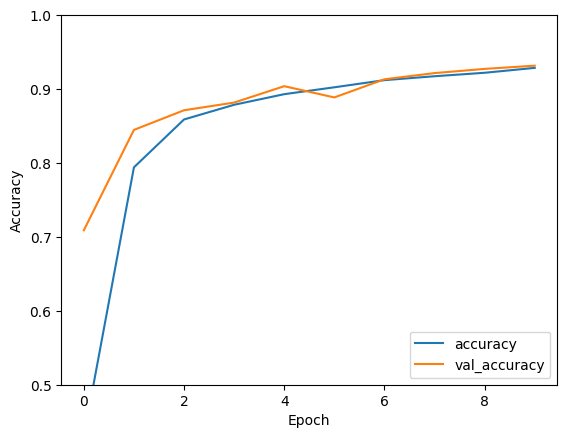

In [56]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(Im_test, xy_test, verbose=2)

In [64]:
# Save the model 
tf_models_dir = os.path.join(os.getcwd(),'tfModel')
if not os.path.isdir(tf_models_dir):
    os.mkdir(tf_models_dir)
model.save(os.path.join(tf_models_dir,'model1.keras'), overwrite=True)

In [58]:
# Predict from the validation 
xy_prediction = model.predict(Im_val)

333/333 [==============================] - 1s 2ms/step
